# Progetto di laboratorio
## Programmazione di Applicazioni Data Intensive

Di:
* Luca Sambuchi (0000801513) (luca.sambuchi@studio.unibo.it)
* Federico Galdenzi (0000801886) (federico.galdenzi@studio.unibo.it)
* Filippo Nardini (0000793827) (filippo.nardini@studio.unibo.it)

Dataset: https://www.kaggle.com/mohansacharya/graduate-admissions

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
%matplotlib inline

# Introduzione
## Importazione del dataset

Questo dataset è stato creato per aiutare gli studenti indiani a stimare la probabilità di essere ammessi ad un corso di laurea magistrale negli Stati Uniti.
Il dataset è composto da 500 record:

In [2]:
data = pd.read_csv("Admission_Predict_Ver1.1.csv")

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 9 columns):
Serial No.           500 non-null int64
GRE Score            500 non-null int64
TOEFL Score          500 non-null int64
University Rating    500 non-null int64
SOP                  500 non-null float64
LOR                  500 non-null float64
CGPA                 500 non-null float64
Research             500 non-null int64
Chance of Admit      500 non-null float64
dtypes: float64(4), int64(5)
memory usage: 35.2 KB


Come prima operazione abbiamo scelto di eliminare la colonna *Serial No.* poiché si tratta semplicemente di un numero incrementale che non aggiunge nessuna informazione.
La seconda cosa che abbiamo notato è che le colonne sono nominate non seguendo nessuna particolare convezione, di conseguenza abbiamo scelto di rinominarle seguendo la convenzione *snake_case* utilizzata in Python.

In [4]:
del data['Serial No.']

In [5]:
def to_snake_case(name):
    return name.lower().strip().replace(" ", "_")

In [6]:
columns = data.columns
to_rename = {}
for c in columns:
    to_rename[c] = to_snake_case(c)
data.rename(columns = to_rename, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
gre_score            500 non-null int64
toefl_score          500 non-null int64
university_rating    500 non-null int64
sop                  500 non-null float64
lor                  500 non-null float64
cgpa                 500 non-null float64
research             500 non-null int64
chance_of_admit      500 non-null float64
dtypes: float64(4), int64(4)
memory usage: 31.3 KB


## Descrizione del dataset

Il dataset presenta due caratteristiche principali: non contiene né stringhe né valori nulli.

A questo punto le variabili del dataset sono le seguenti:
* ```gre_score```: punteggio ottenuto al Graduate Record Examination (su 340)
* ```toefl_score```: punteggio ottenuto al Test of English as a Foreign Language (su 120)
* ```university_rating```: punteggio che descrive il prestigio dell'università di provenienza (su 5)
* ```sop```: punteggio del saggio di domanda (su 5)
* ```lor```: punteggio della lettera di raccomandazione (su 5)
* ```cgpa```: valutazione scolastica (su 10)
* ```research```: precedenti esperienze nell'ambito della ricerca (variabile binaria)
* ```chance_of_admit```: probabilità di essere ammessi

La probabilità di essere ammessi, continua nell'intervallo da 0 a 1, è la variabile dipendente da predire.

In [7]:
data.head()

gre_score  toefl_score  university_rating  sop  lor  cgpa  research  \
0        337          118                  4  4.5  4.5  9.65         1   
1        324          107                  4  4.0  4.5  8.87         1   
2        316          104                  3  3.0  3.5  8.00         1   
3        322          110                  3  3.5  2.5  8.67         1   
4        314          103                  2  2.0  3.0  8.21         0   

   chance_of_admit  
0             0.92  
1             0.76  
2             0.72  
3             0.80  
4             0.65

In [8]:
data.describe()

gre_score  toefl_score  university_rating         sop        lor  \
count  500.000000   500.000000         500.000000  500.000000  500.00000   
mean   316.472000   107.192000           3.114000    3.374000    3.48400   
std     11.295148     6.081868           1.143512    0.991004    0.92545   
min    290.000000    92.000000           1.000000    1.000000    1.00000   
25%    308.000000   103.000000           2.000000    2.500000    3.00000   
50%    317.000000   107.000000           3.000000    3.500000    3.50000   
75%    325.000000   112.000000           4.000000    4.000000    4.00000   
max    340.000000   120.000000           5.000000    5.000000    5.00000   

             cgpa    research  chance_of_admit  
count  500.000000  500.000000        500.00000  
mean     8.576440    0.560000          0.72174  
std      0.604813    0.496884          0.14114  
min      6.800000    0.000000          0.34000  
25%      8.127500    0.000000          0.63000  
50%      8.560000    1.000000          0.72000  
75%      9.040000    1.000000          0.82000  
max      9.920000    1.000000          0.97000

### Correlazione tra le variabili

Tramite una *heatmap* siamo in grado di graficare il grado di correlazione tra le variabili.

La prima cosa che si può notare è come tutte le variabili indipendenti abbiano un buon livello di correlazione positiva con la possibilità di essere ammessi (maggiore di 50).

Le variabili con correlazione forte con quella da predire sono in ordine:

* ```cgpa``` : 88%;
* ```gre_score```: 81%;
* ```toefl_score```: 79%.

Le variabili con correlazione moderata sono:

* ```university_rating```: 69%;
* ```sop```: 68%;
* ```lor```: 65%.

La variabile con correlazione più debole è ```research``` con un punteggio del 55%.

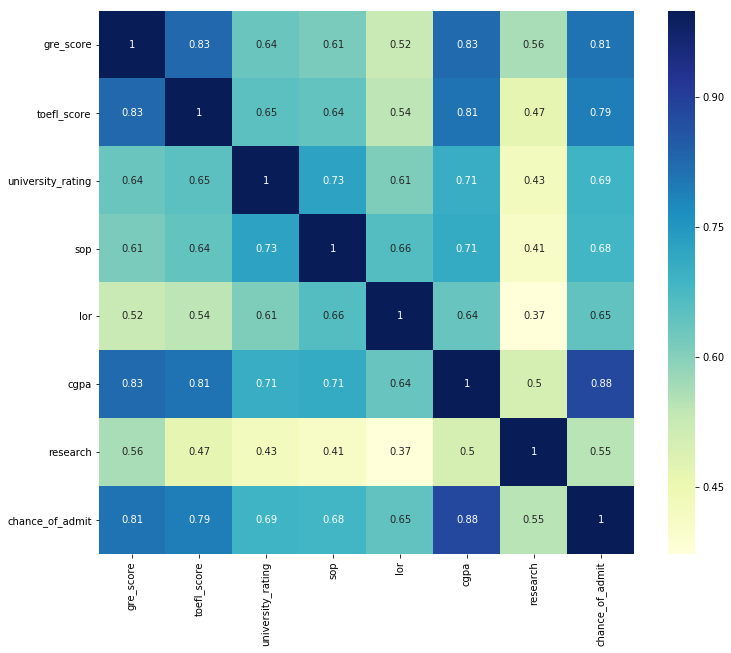

In [9]:
plt.figure(figsize=(12, 10))
sns.heatmap(data.corr(), annot=True, cmap="YlGnBu")

### Analisi delle variabili

I grafici a seguire rappresentano la distribuzione dei valori delle features.

**Valutazione scolastica**, **punteggio GRE**, **punteggio TOEFL**:
* hanno la maggiore correlazione positiva, quindi il peso maggiore sulla probabilità finale
* seguono una distribuzione normale

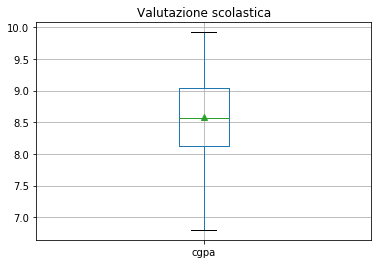

In [10]:
data['cgpa'].plot.box(showmeans=True, title="Valutazione scolastica").grid()

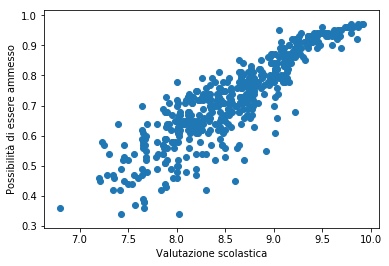

In [11]:
plt.scatter(data["cgpa"], data["chance_of_admit"])
plt.xlabel("Valutazione scolastica")
plt.ylabel("Possibilità di essere ammesso")
plt.show()

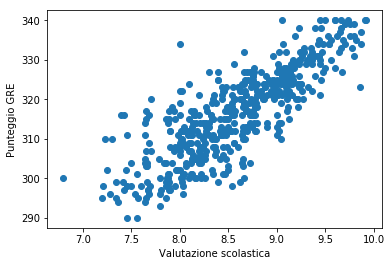

In [12]:
plt.scatter(data["cgpa"], data["gre_score"])
plt.xlabel("Valutazione scolastica")
plt.ylabel("Punteggio GRE")
plt.show()

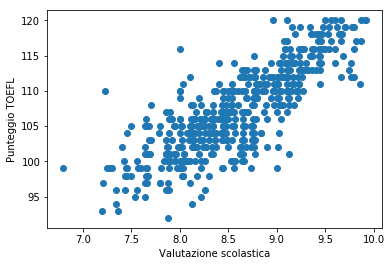

In [13]:
plt.scatter(data["cgpa"], data["toefl_score"])
plt.xlabel("Valutazione scolastica")
plt.ylabel("Punteggio TOEFL")
plt.show()

Dai grafici di dispersione si nota come un'elevata valutazione scolastica sia indice di punteggi elevati nei test GRE e TOEFL, che a loro volta hanno un'elevata correlazione con la probabilità finale.

**Rating dell'università di provenienza**:

* ha anche essa una buona correlazione con la variabile dipendente;
* in media chi proviene da università con rating più alto ha più probabilità di essere ammesso.

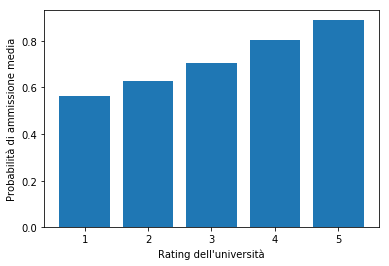

In [14]:
plt.bar(x = [1,2,3,4,5], height=data.groupby("university_rating").mean()["chance_of_admit"])
plt.xlabel("Rating dell'università")
plt.ylabel("Probabilità di ammissione media")
plt.show()

**Saggio di domanda e lettera di ammissione**:

* i dati seguono una distribuzione normale

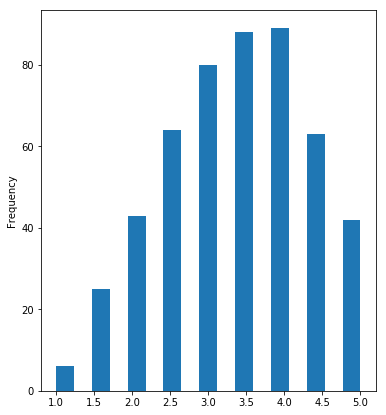

In [15]:
plt.figure(figsize=(6,7))
data["sop"].plot.hist(17)

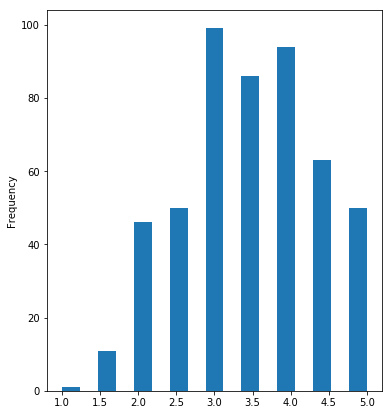

In [16]:
plt.figure(figsize=(6,7))
data["lor"].plot.hist(17)

**Precedenti attività di ricerca:**
* una leggera maggioranza ha precedenti attività di ricerca;
* questa caratteristica è quella tra quelle analizzate quella che è meno correlata con la variabile da predire.

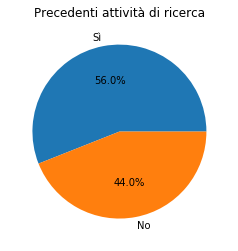

In [17]:
plt.pie(data['research'].value_counts(), labels=["Sì", "No"], autopct='%1.1f%%')
plt.title("Precedenti attività di ricerca")
plt.show()

# Regressione

## Suddivisione del dataset

Abbiamo suddiviso le variabili del dataset in X e y, rispettivamente variabili indipendenti e variabile dipendente.

In [18]:
from sklearn.model_selection import train_test_split

In [19]:
X = data.drop(["chance_of_admit"], axis=1)
y = data["chance_of_admit"]

Dopodiché abbiamo suddiviso i record in due insiemi disgiunti: _training set_ e _validation set_ utilizzando come dimensione di quest'ultimo 1/3 del totale. 

In [20]:
X_train, X_val, y_train, y_val = train_test_split(
    X,
    y,
    test_size=1/3, random_state=42
)

X_train = X_train.astype(np.float64)
X_val = X_val.astype(np.float64)

## Regressione lineare

Come primo modello di regressione abbiamo utilizzato quello lineare.

In [21]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

Abbiamo riutilizzato le funzioni proposte durante le lezioni di laboratorio per la valutazione dei seguenti paramentri: scarto quadratico medio, errore relativo e il coefficiente $R^2$.

In [22]:
def relative_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true))

In [23]:
def print_eval(X, y, model):
    print("   Mean squared error: {:.5}".format(mean_squared_error(model.predict(X), y)))
    print("       Relative error: {:.5%}".format(relative_error(model.predict(X), y)))
    print("R-squared coefficient: {:.5}".format(model.score(X, y)))

In [24]:
lrm = LinearRegression()
lrm.fit(X_train, y_train)
print_eval(X_val, y_val, lrm)

   Mean squared error: 0.0035787
       Relative error: 6.34418%
R-squared coefficient: 0.82459


## Regressione lineare con 3 campi più correlati

Utilizzando solo i 3 campi più correlati alla probabilità di ammissione otteniamo comunque un risultato più che accettabile.

In [25]:
fields = ["gre_score", "toefl_score", "cgpa"]
lrm = LinearRegression()
lrm.fit(X_train[fields], y_train)
print_eval(X_val[fields], y_val, lrm)

   Mean squared error: 0.0041112
       Relative error: 6.71387%
R-squared coefficient: 0.79849


## Regressione non lineare

Abbiamo provato ad utilizzare un grado del polinomio maggiore di 1 per vedere se ci sono miglioramenti nel modello.

Abbiamo utilizzato una ```Pipeline``` per applicare un filtro di trasformazione polinomiale ai dati in input per poi passarli alla funzione di regressione lineare.

In [26]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

In [27]:
prm = Pipeline ([
    ("poly",    PolynomialFeatures(degree=2, include_bias=False)),
    ("linreg",  LinearRegression())
])
prm.fit(X_train, y_train)
print_eval(X_val, y_val, prm)

   Mean squared error: 0.0036268
       Relative error: 6.30643%
R-squared coefficient: 0.82223


## Normalizzazione dei dati

Dato che i dati utilizzati durante le precedenti regressioni non erano normalizzati abbiamo provato a normalizzarli, per vedere se ci fossero miglioramenti.

In [28]:
from sklearn.preprocessing import MinMaxScaler

In [29]:
prm = Pipeline([
    ("poly",   PolynomialFeatures(degree=2, include_bias=False)),
    ("scale",  MinMaxScaler()),
    ("linreg", LinearRegression())
])
prm.fit(X_train, y_train)
print_eval(X_val, y_val, prm)

   Mean squared error: 0.0036268
       Relative error: 6.30643%
R-squared coefficient: 0.82223


## Standardizzazione

Notando che tutti i dati hanno una distrubizione normale, abbiamo pensato di controllare anche se con una standardizzazione ci potessero essere dei miglioramenti.

In [30]:
from sklearn.preprocessing import StandardScaler

In [31]:
prm = Pipeline([
    ("poly",   PolynomialFeatures(degree=2, include_bias=False)),
    ("scale",  StandardScaler()),
    ("linreg", LinearRegression())
])
prm.fit(X_train, y_train)
print_eval(X_val, y_val, prm)

   Mean squared error: 0.0036268
       Relative error: 6.30643%
R-squared coefficient: 0.82223


In entrambi i casi le metriche di accuratezza non sono cambiate, perchè abbiamo utilizzato un grado del polinomio piccolo.

Ora, proviamo ad aumentare il grado della regressione polinomiale.

In [32]:
prm = Pipeline([
    ("poly",   PolynomialFeatures(degree=4, include_bias=False)),
    ("scale",  StandardScaler()),
    ("linreg", LinearRegression())
])
prm.fit(X_train, y_train)
print_eval(X_val, y_val, prm)

   Mean squared error: 1.6176
       Relative error: 1073.59430%
R-squared coefficient: -78.289


In [33]:
print_eval(X_train, y_train, prm)

   Mean squared error: 0.00022012
       Relative error: 1.30341%
R-squared coefficient: 0.98875


Utilizzando un polinomio di grado maggiore di 2 il modello si adatta troppo alle istanze del training set e non al problema generico. Proviamo a risolverlo applicando la regolarizzazione.

## Regressione Ridge

Controlliamo i coefficenti del modello precedente, prima di effettuare la regressione Ridge: notiamo che il valore assoluto dei coefficienti è alto.

In [34]:
prm.named_steps["linreg"].coef_[:10]

array([ -3150.65540343,   4844.28402314,  -4838.87704521,   2792.96488336,
         6998.62988706,  -3501.59858281,  -1081.0739331 ,  12403.17789565,
       -20261.61123152,  17556.53298563])

In [35]:
from sklearn.linear_model import Ridge
rrm = Pipeline([
    ("poly", PolynomialFeatures(degree=4, include_bias=False)),
    ("scale", StandardScaler()),
    ("linreg", Ridge(alpha=20))
])
rrm.fit(X_train, y_train)
print_eval(X_val, y_val, rrm)

   Mean squared error: 0.0035099
       Relative error: 6.35313%
R-squared coefficient: 0.82796


In [36]:
rrm.named_steps["linreg"].coef_[:10]

array([ 0.00451024,  0.00486007,  0.00203772,  0.00130869,  0.00568566,
        0.01613903, -0.00070124,  0.00290533,  0.00329774,  0.00110188])

Il valore assoluto dei coefficenti, dopo aver applicato la regressione Ridge, è diminuito, inoltre possiamo notare che a parità di grado del polinomio, cioè 4, abbiamo risolto il problema dell'overfitting sui dati del training set.

## Regressione lasso

Applichiamo la regressione lasso e vediamo che azzerando i parametri con rilevanza minore non otteniamo risultati migliori.
Il motivo di questi risultati è che abbiamo una correlazione tra le varibiali abbastanza forte dato che il minimo valore di correlazione tra la variabile dipendente e le variabili indipendenti è del 55%.

In [37]:
from sklearn.linear_model import Lasso

In [38]:
model = Pipeline([
    ("scale", StandardScaler()),
    ("linreg", Lasso(alpha=0.04))
])
model.fit(X_train, y_train)
print_eval(X_val, y_val, model)

   Mean squared error: 0.0057036
       Relative error: 8.20979%
R-squared coefficient: 0.72043


In [39]:
pd.Series(model.named_steps["linreg"].coef_, X_train.columns)

gre_score            0.013738
toefl_score          0.004293
university_rating    0.000000
sop                  0.000000
lor                  0.000000
cgpa                 0.068511
research             0.000000
dtype: float64

Con un alpha pari a 0.04, notiamo che le tre feature più rilevanti sono quelle con coefficente diverso da zero, come si può dedurre guardando i dati della correlazione.

## Elastic net

In [40]:
from sklearn.linear_model import ElasticNet

In [41]:
model = Pipeline([
    ("scale", StandardScaler()),
    ("linreg", ElasticNet(alpha=0.1, l1_ratio=0.2))
])
model.fit(X_train, y_train)
print_eval(X_val, y_val, model)

   Mean squared error: 0.0043827
       Relative error: 7.03936%
R-squared coefficient: 0.78518


## K-fold cross validation

Utilizziamo la libreria ```KFold``` per generare un oggetto che genera 4 fold con dati mescolati casualmente.

In [42]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [43]:
kf = KFold(4, shuffle=True, random_state=42)
model = Pipeline([
    ("poly",    PolynomialFeatures(degree=4, include_bias=False)),
    ("scale",   StandardScaler()),
    ("linreg",  Ridge(alpha=20))
])
r_squared = cross_val_score(model, X, y, cv=kf)

Eseguiamo una validazione di un modello sui diversi fold generati tramite la funzione ```cross_val_score```

In questo modo otteniamo una valutazione più affidabile di quella ottenuta con il metodo hold-out, in quanto ci permette di valutare il modello su set diversi di dati.

Non sappiamo se il parametro $R^2$ è ottimale, in quanto non abbiamo calcolato i parametri ottimali degli iper-piani.

In [44]:
r_squared

array([0.82013583, 0.77554101, 0.81824963, 0.8433943 ])

In [45]:
r_squared.mean()

0.8143301906647672

In [46]:
r_squared.std()

0.024486683858069878

## Ricerca dei parametri degli iperpiani ottimali



### Definizione di funzioni helper

Ci avvaliamo della definizione di funzioni per la creazione di modelli di regressione.

Inoltre definiamo gli iperparametri da testare per trovare la combinazione migliore di essi.

In [47]:
grid_elastic_net = { 
    "linreg__alpha": np.arange(0.01, 1.001, 0.04),
    "linreg__l1_ratio": np.arange(0.01, 1.0001, 0.04)
}
grid_ridge = {
    "regr__alpha":  np.arange(0.05, 5, 0.05),
    "poly__degree": [2, 3]
}
grid_lasso = {
    "linreg__alpha": np.arange(0.0001, 0.09, 0.0001)
}

def model_elastic_net_pipe(alpha=None, l1_ratio=None):
    return Pipeline([
        ("scale", StandardScaler()),
        ("linreg", ElasticNet(alpha=alpha,l1_ratio=l1_ratio))
    ])

def model_ridge_pipe(degree=None, alpha=None):
    return Pipeline([
        ("poly", PolynomialFeatures(degree,include_bias=False)),
        ("scale", StandardScaler()),
        ("regr", Ridge(alpha))
    ])

def model_lasso_pipe(alpha=None):
    return Pipeline([
        ("scale", StandardScaler()),
        ("linreg", Lasso(alpha=alpha))
    ])

def print_best_params(model):
    print("Best params: ", model.best_params_)


### Grid Search

Definiamo una funzione per la ricerca dei parametri degli iperpiani che utilizza la Grid Search.

In [48]:
from sklearn.model_selection import GridSearchCV

def gs_find_best_params(model_pipe_function, grid, X, y):
    model = model_pipe_function()
    gs = GridSearchCV(model, param_grid=grid,cv=5, iid=True)
    gs.fit(X, y)
    return gs

### Random Search

Si differenzia dalla Grid Search per i tempi migliori di esecuzione: è molto efficiente rispetto alla GS e trova un valore abbastanza vicino a quello ottimo.

Nel nostro caso non è necessario utilizzare una random search in quanto il numero di istanze e di parametri è limitato.

In [49]:
from sklearn.model_selection import RandomizedSearchCV

def rs_find_best_params(model_pipe_function, grid, X, y):
    model = model_pipe_function()
    rs = RandomizedSearchCV(model, param_distributions=grid,cv=5, random_state=42, iid=True)
    rs.fit(X, y)
    return rs

Nell'esempio seguente si può vedere come la random search impieghi un tempo notevolmente inferiore a quello della grid search.

In [50]:
print("Grid Search...")
%time gs_ridge = gs_find_best_params(model_ridge_pipe, grid_ridge, X_train.astype(np.float64), y_train)
print("Random Search...")
%time rs_ridge = rs_find_best_params(model_ridge_pipe, grid_ridge, X_train.astype(np.float64), y_train)
print()
print("Grid Search params: ", gs_ridge.best_params_)
print("Random Search params: ", rs_ridge.best_params_)
print()
print("Valutazione modello GS: ")
print_eval(X_val, y_val, gs_ridge)
print()
print("Valutazione modello RS: ")
print_eval(X_val, y_val, rs_ridge)

Grid Search...
Wall time: 8.36 s
Random Search...
Wall time: 589 ms

Grid Search params:  {'poly__degree': 3, 'regr__alpha': 0.9500000000000001}
Random Search params:  {'regr__alpha': 0.8, 'poly__degree': 3}

Valutazione modello GS: 
   Mean squared error: 0.0035026
       Relative error: 6.25107%
R-squared coefficient: 0.82832

Valutazione modello RS: 
   Mean squared error: 0.0035108
       Relative error: 6.25114%
R-squared coefficient: 0.82792


## Valutazione dei modelli migliori

Scegliamo di analizzare i modelli:

* lineare;
* Ridge;
* Elastic net.

Per gli ultimi due dobbiamo ricercare i parametri migliori.

In [51]:
%time ridge = gs_find_best_params(model_ridge_pipe, grid_ridge, X_train, y_train)
print_best_params(ridge)
print_eval(X_val, y_val, ridge)

Wall time: 7.95 s
Best params:  {'poly__degree': 3, 'regr__alpha': 0.9500000000000001}
   Mean squared error: 0.0035026
       Relative error: 6.25107%
R-squared coefficient: 0.82832


In [52]:
%time elastic_net = gs_find_best_params(model_elastic_net_pipe, grid_elastic_net, X_train.astype(np.float64), y_train)
print_best_params(elastic_net)
print_eval(X_val.astype(np.float64), y_val, elastic_net)

Wall time: 15.3 s
Best params:  {'linreg__alpha': 0.01, 'linreg__l1_ratio': 0.09}
   Mean squared error: 0.00358
       Relative error: 6.32183%
R-squared coefficient: 0.82453


La regressione lineare non ha parametri

In [53]:
linear = LinearRegression()
%time linear.fit(X_train, y_train)
print_eval(X_val, y_val, linear)

Wall time: 2.01 ms
   Mean squared error: 0.0035787
       Relative error: 6.34418%
R-squared coefficient: 0.82459


## Scelta del modello migliore

Alla luce dei dati analizzati abbiamo scelto come modelli migliori quelli prodotti dalla regressione Ridge e lineare:

* il modello prodotto dalla regressione Ridge è un polinomio di grado 3;
* il modello lineare ha i parametri di valutazione molto simili e una complessità computazionale minore
* se si dovesse prendere in considerazione esclusivamente il risultato migliore scegliamo il primo;
* nel momento in cui le prestazioni e i tempi di esecuzione entrano in gioco, il migliore tra i due è certamente quello lineare che ha tempi di esecuzione minori di svariati ordini di grandezza